In [ ]:
#install suprise on colab
pip install surprise

In [ ]:
#downgrade numpy to v1 becuase suprise only support v1
pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
#load all require modules
from surprise import Dataset, model_selection
from surprise.model_selection import train_test_split
from surprise import SVD, CoClustering, SlopeOne, NormalPredictor
from surprise import accuracy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  io import StringIO # dealing with .dat files
import os
import kagglehub
from surprise import Reader
import sklearn

In [ ]:
kSplit = model_selection.split.KFold(n_splits=10, shuffle=True) # split data into 10 folds.

In [ ]:
# Load MovieLens
data_ml = Dataset.load_builtin('ml-1m')
trainset, testset = train_test_split(data_ml, test_size=0.2)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


In [ ]:
#dic of list for RMSE of movielens 1m
rmseml= {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}
#dic of list for MAE of movielens 1m
maeml = {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}

In [ ]:
#dict of CF models for movielens
models_ml = {
    'svd': SVD(n_factors=30,n_epochs=10,biased=True),
    'cocluster': CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25),
    'slopeone': SlopeOne(),
    'normalpredictor': NormalPredictor()
}

# Train, predict, and evaluate RMSE & MAE for each model
print('Start Evalaution...')
for name, model in models_ml.items():
    print(f"Evaluating {name.upper()}...")
    for trainset, testset in kSplit.split(data_ml): #iterate through the folds.
      model.fit(trainset)
      predictions = model.test(testset)

      #print(f"\n{name.upper()} Evaluation:")
      rmseml[name].append(accuracy.rmse(predictions, verbose=False))
      maeml[name].append(accuracy.mae(predictions, verbose=False))
print('Finished Evalaution...')

Start Evalaution...
Evaluating SVD...
Evaluating COCLUSTER...
Evaluating SLOPEONE...
Evaluating NORMALPREDICTOR...
Finished Evalaution...


In [ ]:
#print all the mocdels RMSE and MAE
print("SVD Evaluation RMSE: " + str(np.mean(rmseml['svd'])))
print("SVD Evaluation MAE: " +str(np.mean(maeml['svd'])))
print("Coclustering Evaluation RMSE: " +str(np.mean(rmseml['cocluster'])))
print("Coclustering Evaluation MAE: " +str(np.mean(maeml['cocluster'])))
print("Slopeone Evaluation RMSE: "+str(np.mean(rmseml['slopeone'])))
print("Slopeone Evaluation MAE: "+str(np.mean(maeml['slopeone'])))
print("NormalPredictor Evaluation RMSE: "+str(np.mean(rmseml['normalpredictor'])))
print("NormalPredictor Evaluation MAE: "+str(np.mean(maeml['normalpredictor'])))

SVD Evaluation RMSE: 0.8913338660781429
SVD Evaluation MAE: 0.7046401786673232
Coclustering Evaluation RMSE: 0.9075366152132961
Coclustering Evaluation MAE: 0.7115464193926495
Slopeone Evaluation RMSE: 0.9056858265401765
Slopeone Evaluation MAE: 0.7138103709603484
NormalPredictor Evaluation RMSE: 1.506026489714452
NormalPredictor Evaluation MAE: 1.2074873308124383


In [ ]:
#crate user-item matrix with the models predictions which can be used for the linear regression learner
meta_data = []

for uid, iid, true_r in testset:
    preds = {
        'user': uid,
        'item': iid,
        'true': true_r
    }
    for name, model in models_ml.items():
        pred = model.predict(uid, iid).est
        preds[name] = pred
    meta_data.append(preds)

df_meta = pd.DataFrame(meta_data)

In [ ]:
#print sample user-item matrix
df_meta.head(10)

,user,item,true,svd,cocluster,slopeone,normalpredictor
0,2846,588,4.0,3.473862,3.471362,3.338026,3.966452
1,4498,2390,2.0,3.321958,3.328640,3.288727,2.348947
2,4163,2688,3.0,3.108509,2.555546,2.859590,2.616543
3,5996,3197,5.0,3.723064,3.819849,3.646742,5.000000
4,3846,2243,5.0,4.100153,4.315664,4.008736,3.952951
5,5026,1015,4.0,2.812180,2.912844,2.850484,3.457972
6,1227,3903,5.0,3.538457,3.626003,3.720111,2.754949
7,3418,949,3.0,4.325454,4.375047,4.039735,2.263351
8,601,1916,4.0,3.307751,3.245534,3.343244,5.000000
9,3454,2718,1.0,2.979499,3.222213,3.111439,3.958099


In [ ]:
# Feature selection
X = df_meta[['svd', 'cocluster', 'slopeone', 'normalpredictor']]
y = df_meta['true']

# Train-test split
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
meta_model = LinearRegression()
meta_model.fit(X_train, y_train)

# Predict
y_pred = meta_model.predict(X_val)

# Calculate RMSE and MAE
rmseml_ensemble = np.sqrt(mean_squared_error(y_val, y_pred))
maeml_ensemble = mean_absolute_error(y_val, y_pred)

# Print results
print(f"Linear Regression Meta-Model RMSE: {rmseml_ensemble:.4f}")
print(f"Linear Regression Meta-Model MAE : {maeml_ensemble:.4f}")

Linear Regression Meta-Model RMSE: 0.8554
Linear Regression Meta-Model MAE : 0.6742


In [ ]:
#add hybrid result
rmseml.update({'ensemble': [rmseml_ensemble]})
maeml.update({'ensemble': [maeml_ensemble]})

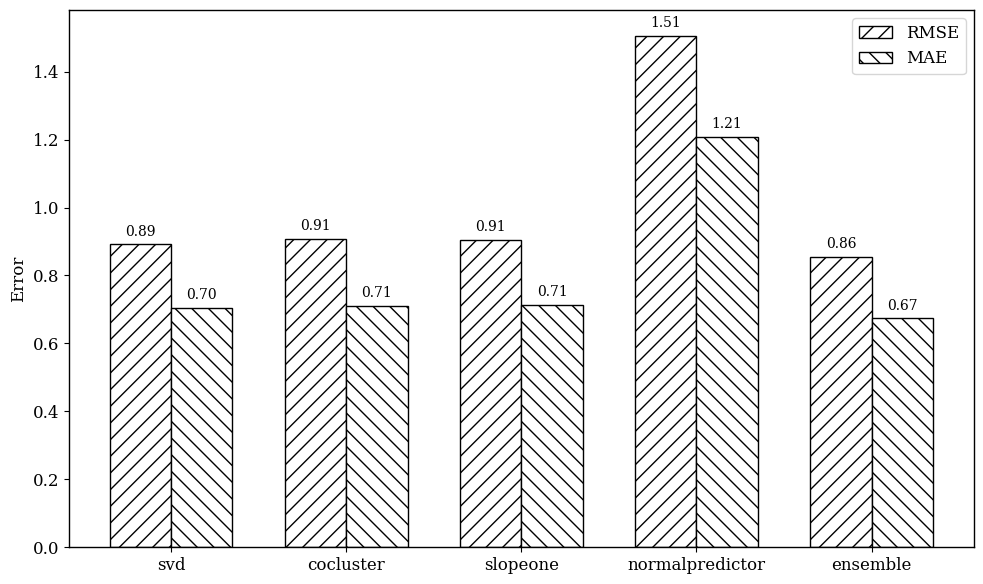

In [ ]:
import matplotlib.pyplot as plt

models = list(rmseml.keys())
n_models = len(models)
x = np.arange(n_models)

# Compute average RMSE and MAE for each model
avg_rmse = [np.mean(rmseml[model]) for model in models]
avg_mae = [np.mean(maeml[model]) for model in models]

# Font and figure settings
font_name = 'serif'  # Use standard, highly legible font
plt.rcParams.update({'font.size': 12, 'font.family': font_name})

# Bar chart setup
width = 0.35  # width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars using black and hatch patterns
bars1 = ax.bar(x - width/2, avg_rmse, width, label='RMSE',
               color='white', edgecolor='black', hatch='//', linewidth=1)
bars2 = ax.bar(x + width/2, avg_mae, width, label='MAE',
               color='white', edgecolor='black', hatch='\\\\', linewidth=1)

# Axis labels and title
ax.set_ylabel('Error', fontsize=12)
#ax.set_title('Average RMSE and MAE by Model', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Annotate bar values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Increase axis line width
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Final layout
plt.tight_layout()

# Save figure in high-quality format
#plt.savefig('bar_result_movielens.tiff', dpi=1200, format='tiff')  # For bitmap submission
plt.savefig('bar_result_movielens.pdf')  # For vector-based submission
plt.show()

Jester joke ratings

In [ ]:
#load jester dataset path from kaggle
pathJester = kagglehub.dataset_download("vikashrajluhaniwal/jester-17m-jokes-ratings-dataset")

100%|██████████| 8.00M/8.00M [00:00<00:00, 47.8MB/s]

Extracting files...


In [ ]:
#load the dataset using pandas
ratingsJester = pd.read_csv(pathJester+'/jester_ratings.csv', on_bad_lines='skip', encoding="latin-1",low_memory=False)

In [ ]:
#jester summary
ratingsJester.drop_duplicates(inplace=True)
print('we have',ratingsJester.shape[0], 'ratings')
print('the number of unique users we have is:', len(ratingsJester['userId'].unique()))
print('the number of unique jokes we have is:', len(ratingsJester.jokeId.unique()))
print("The median user rated %d jokes."%ratingsJester['userId'].value_counts().median())
print('The max rating is: %d'%ratingsJester['rating'].max(),"the min rating is: %d"%ratingsJester['rating'].min())
ratingsJester.head(5)

In [ ]:
#Normalize rating 0 to 2
ratingsJester['rating'] = (ratingsJester['rating'] + 10) / ratingsJester['rating'].max()

In [ ]:
#jester summary
print('we have',ratingsJester.shape[0], 'ratings')
print('the number of unique users we have is:', len(ratingsJester['userId'].unique()))
print('the number of unique jokes we have is:', len(ratingsJester.jokeId.unique()))
print("The median user rated %d jokes."%ratingsJester['userId'].value_counts().median())
print('The max rating is: %d'%ratingsJester['rating'].max(),"the min rating is: %d"%ratingsJester['rating'].min())
ratingsJester.head(5)

we have 1761439 ratings
the number of unique users we have is: 59132
the number of unique jokes we have is: 140
The median user rated 16 jokes.
The max rating is: 2 the min rating is: 0


,userId,jokeId,rating
0,1,5,1.0219
1,1,7,0.0719
2,1,8,0.0719
3,1,13,0.3219
4,1,15,1.0875


In [ ]:
#assign rating scale
reader = Reader(rating_scale=(0,2))
#into surprise:
data_jester = Dataset.load_from_df(ratingsJester,reader)
trainset, testset = train_test_split(data_jester, test_size=0.2)

In [ ]:
#dic of list for RMSE of Jester
rmseJester = {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}
#dic of list for MAE of Jester
maeJester = {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}

In [ ]:
#dict of CF models for jester
models_jester = {
    'svd': SVD(n_factors=30,n_epochs=10,biased=True),
    'cocluster': CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25),
    'slopeone': SlopeOne(),
    'normalpredictor': NormalPredictor()
}

# Train, predict, and evaluate RMSE & MAE for each model
print('Start Evalaution...')
for name, model in models_jester.items():
    print(f"Evaluating {name.upper()}...")
    for trainset, testset in kSplit.split(data_jester): #iterate through the folds.
      model.fit(trainset)
      predictions = model.test(testset)

      #print(f"\n{name.upper()} Evaluation:")
      rmseJester[name].append(accuracy.rmse(predictions, verbose=False))
      maeJester[name].append(accuracy.mae(predictions, verbose=False))
print('Finished Evalaution...')

Start Evalaution...
Evaluating SVD...
Evaluating COCLUSTER...
Evaluating SLOPEONE...
Evaluating NORMALPREDICTOR...
Finished Evalaution...


In [ ]:
#print all the mocdels RMSE and MAE
print("SVD Evaluation RMSE: " + str(np.mean(rmseJester['svd'])))
print("SVD Evaluation MAE: " +str(np.mean(maeJester['svd'])))
print("Coclustering Evaluation RMSE: " +str(np.mean(rmseJester['cocluster'])))
print("Coclustering Evaluation MAE: " +str(np.mean(maeJester['cocluster'])))
print("Slopeone Evaluation RMSE: "+str(np.mean(rmseJester['slopeone'])))
print("Slopeone Evaluation MAE: "+str(np.mean(maeJester['slopeone'])))
print("NormalPredictor Evaluation RMSE: "+str(np.mean(rmseJester['normalpredictor'])))
print("NormalPredictor Evaluation MAE: "+str(np.mean(maeJester['normalpredictor'])))

SVD Evaluation RMSE: 0.4325047570155913
SVD Evaluation MAE: 0.3393349134504885
Coclustering Evaluation RMSE: 0.6678483854641768
Coclustering Evaluation MAE: 0.5646589554360165
Slopeone Evaluation RMSE: 0.42496855489321766
Slopeone Evaluation MAE: 0.32338811847468973
NormalPredictor Evaluation RMSE: 0.7270571784671968
NormalPredictor Evaluation MAE: 0.5878256046857273


In [ ]:
#crate user-item matrix with the models predictions which can be used for the linear regression learner
meta_data_jester = []

for uid, iid, true_r in testset:
    preds = {
        'user': uid,
        'item': iid,
        'true': true_r
    }
    for name, model in models_jester.items():
        pred = model.predict(uid, iid).est
        preds[name] = pred
    meta_data_jester.append(preds)

df_meta_jester = pd.DataFrame(meta_data_jester)

In [ ]:
#print sample user-item matrix
df_meta_jester.head(10)

,user,item,true,svd,cocluster,slopeone,normalpredictor
0,40531,16,0.9219,1.036669,0.365042,1.202455,0.302020
1,35148,63,1.8812,0.962219,0.590716,1.069992,0.826654
2,52838,18,0.8281,0.835461,0.056324,0.593499,1.303795
3,48768,19,0.2656,1.019179,0.210752,0.943992,1.348074
4,51385,68,0.9094,1.445374,1.010244,1.519828,0.878596
5,13788,25,1.2062,0.934171,0.704562,1.017680,0.366998
6,12803,112,1.0125,1.198349,0.704033,1.269617,1.575540
7,47995,36,1.5719,1.322008,0.965833,1.382212,1.081901
8,52920,7,1.2500,1.220529,0.746632,1.351188,0.753824
9,40139,99,1.9875,1.830052,1.064642,1.918622,1.062262


In [ ]:
# Feature selection
X = df_meta_jester[['svd', 'cocluster', 'slopeone', 'normalpredictor']]
y = df_meta_jester['true']

# Train-test split
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
meta_model = LinearRegression()
meta_model.fit(X_train, y_train)

# Predict
y_pred = meta_model.predict(X_val)

# Calculate RMSE and MAE
rmsej_ensemble = np.sqrt(mean_squared_error(y_val, y_pred))
maemlj_ensemble = mean_absolute_error(y_val, y_pred)

# Print results
print(f"Linear Regression Meta-Model RMSE: {rmsej_ensemble:.4f}")
print(f"Linear Regression Meta-Model MAE : {maemlj_ensemble:.4f}")

Linear Regression Meta-Model RMSE: 0.4073
Linear Regression Meta-Model MAE : 0.3106


In [ ]:
#add hybrid result
rmseJester.update({'ensemble': [rmsej_ensemble]})
maeJester.update({'ensemble': [maemlj_ensemble]})

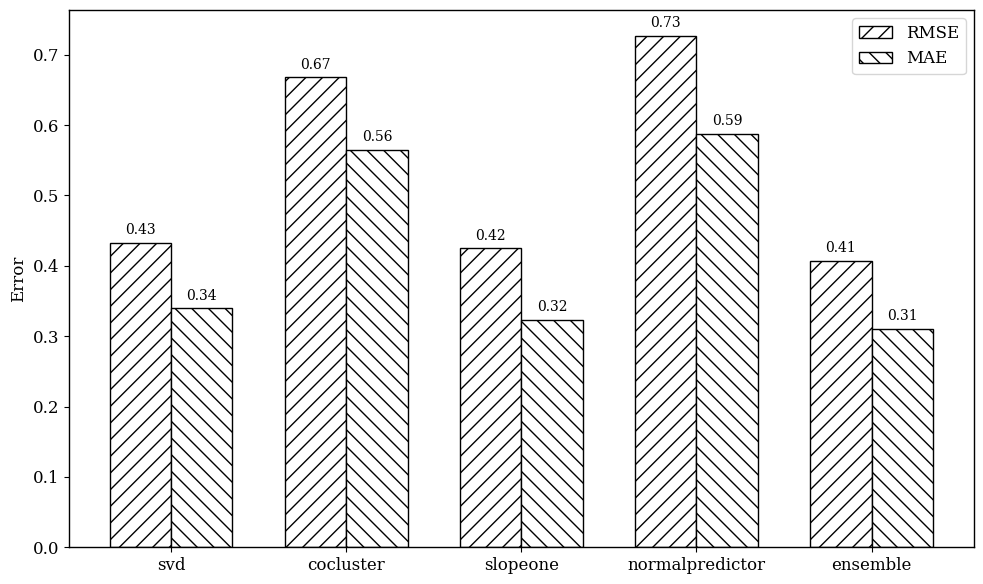

In [ ]:
import matplotlib.pyplot as plt

models = list(rmseJester.keys())
n_models = len(models)
x = np.arange(n_models)

# Compute average RMSE and MAE for each model
avg_rmse = [np.mean(rmseJester[model]) for model in models]
avg_mae = [np.mean(maeJester[model]) for model in models]

# Font and figure settings
font_name = 'serif'  # Use standard, highly legible font
plt.rcParams.update({'font.size': 12, 'font.family': font_name})

# Bar chart setup
width = 0.35  # width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars using black and hatch patterns
bars1 = ax.bar(x - width/2, avg_rmse, width, label='RMSE',
               color='white', edgecolor='black', hatch='//', linewidth=1)
bars2 = ax.bar(x + width/2, avg_mae, width, label='MAE',
               color='white', edgecolor='black', hatch='\\\\', linewidth=1)

# Axis labels and title
ax.set_ylabel('Error', fontsize=12)
#ax.set_title('Average RMSE and MAE by Model', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Annotate bar values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Increase axis line width
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Final layout
plt.tight_layout()

# Save figure in high-quality format
#plt.savefig('bar_result_movielens.tiff', dpi=1200, format='tiff')  # For bitmap submission
plt.savefig('bar_result_jester.pdf')  # For vector-based submission
plt.show()

In [ ]:
pathNetflix = kagglehub.dataset_download("rishitjavia/netflix-movie-rating-dataset")

#print("Path to dataset files:", os.listdir(path))

100%|██████████| 74.7M/74.7M [00:00<00:00, 150MB/s]

Extracting files...


In [ ]:
#ratingsNetflix = pd.read_csv(pathNetflix+'/Netflix_Dataset_Rating.csv', on_bad_lines='skip', encoding="latin-1",low_memory=False)
import random
target = 1_000_000
factor = 10  # tune to pick smaller chunks
chunksize = target // factor

target = 1_000_000
total_rows = 17_000_000
# skiprows is a function: return True to skip, False to keep
ratingsNetflix = pd.read_csv(
    pathNetflix + '/Netflix_Dataset_Rating.csv',
    on_bad_lines='skip',
    encoding='latin-1',
    low_memory=False,
    skiprows=lambda i: i > 0 and random.random() > (target / total_rows)
)

In [ ]:
#Netflix summary
ratingsNetflix.drop_duplicates(inplace=True)
print('we have',ratingsNetflix.shape[0], 'ratings')
print('the number of unique users we have is:', len(ratingsNetflix['User_ID'].unique()))
print('the number of unique movies we have is:', len(ratingsNetflix.Movie_ID.unique()))
print("The median user rated %d Movies."%ratingsNetflix['User_ID'].value_counts().median())
print('The max rating is: %d'%ratingsNetflix['Rating'].max(),"the min rating is: %d"%ratingsNetflix['Rating'].min())
ratingsNetflix.head(5)

we have 1019920 ratings
the number of unique users we have is: 141856
the number of unique movies we have is: 1350
The median user rated 6 Movies.
The max rating is: 5 the min rating is: 1


,User_ID,Rating,Movie_ID
0,1275804,4,3
1,1204327,4,3
2,1959707,3,3
3,2554745,4,3
4,2186436,2,3


In [ ]:
ratingsNetflix = ratingsNetflix[['User_ID', 'Movie_ID', 'Rating']]

In [ ]:
ratingsNetflix.head(5)

,User_ID,Movie_ID,Rating
0,1275804,3,4
1,1204327,3,4
2,1959707,3,3
3,2554745,3,4
4,2186436,3,2


In [ ]:
#netflix data
reader = Reader(rating_scale=(1,5))
#into surprise:
data_netflix = Dataset.load_from_df(ratingsNetflix,reader)
trainset, testset = train_test_split(data_netflix, test_size=0.2)

In [ ]:
#dic of list for RMSE of Netflix
rmseNetflix = {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}
#dic of list for MAE of Netflix
maeNetflix = {
    'svd': [],
    'cocluster': [],
    'slopeone': [],
    'normalpredictor': []
}

In [ ]:
#dict of CF models for netflix
odels_netflix = {
    'svd': SVD(n_factors=30,n_epochs=10,biased=True),
    'cocluster': CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25),
    'slopeone': SlopeOne(),
    'normalpredictor': NormalPredictor()
}

# Train, predict, and evaluate RMSE & MAE for each model
print('Start Evalaution...')
for name, model in models_netflix.items():
    print(f"Evaluating {name.upper()}...")
    for trainset, testset in kSplit.split(data_netflix): #iterate through the folds.
      model.fit(trainset)
      predictions = model.test(testset)

      #print(f"\n{name.upper()} Evaluation:")
      rmseNetflix[name].append(accuracy.rmse(predictions, verbose=False))
      maeNetflix[name].append(accuracy.mae(predictions, verbose=False))
print('Finished Evalaution...')

Start Evalaution...
Evaluating SVD...
Evaluating COCLUSTER...
Evaluating SLOPEONE...
Evaluating NORMALPREDICTOR...
Finished Evalaution...


In [ ]:
#print all the mocdels RMSE and MAE
print("SVD Evaluation RMSE: " + str(np.mean(rmseNetflix['svd'])))
print("SVD Evaluation MAE: " +str(np.mean(maeNetflix['svd'])))
print("Coclustering Evaluation RMSE: " +str(np.mean(rmseNetflix['cocluster'])))
print("Coclustering Evaluation MAE: " +str(np.mean(maeNetflix['cocluster'])))
print("Slopeone Evaluation RMSE: "+str(np.mean(rmseNetflix['slopeone'])))
print("Slopeone Evaluation MAE: "+str(np.mean(maeNetflix['slopeone'])))
print("NormalPredictor Evaluation RMSE: "+str(np.mean(rmseNetflix['normalpredictor'])))
print("NormalPredictor Evaluation MAE: "+str(np.mean(maeNetflix['normalpredictor'])))

SVD Evaluation RMSE: 0.9561546816686795
SVD Evaluation MAE: 0.7625485699737442
Coclustering Evaluation RMSE: 1.0412342221436877
Coclustering Evaluation MAE: 0.8108070474519066
Slopeone Evaluation RMSE: 1.0015809763828531
Slopeone Evaluation MAE: 0.7783447334493506
NormalPredictor Evaluation RMSE: 1.4398712502668642
NormalPredictor Evaluation MAE: 1.154738314399451


In [ ]:
#crate user-item matrix with the models predictions which can be used for the linear regression learner
meta_data_netflix = []

for uid, iid, true_r in testset:
    preds = {
        'user': uid,
        'item': iid,
        'true': true_r
    }
    for name, model in models_netflix.items():
        pred = model.predict(uid, iid).est
        preds[name] = pred
    meta_data_netflix.append(preds)

df_meta_netflix = pd.DataFrame(meta_data_netflix)

In [ ]:
#print sample user-item matrix
df_meta_netflix.head(10)

,user,item,true,svd,cocluster,slopeone,normalpredictor
0,615711,2172,5.0,4.453617,4.691230,4.863170,2.813217
1,1784146,3224,3.0,3.567389,3.396585,3.398148,4.109544
2,407966,1073,4.0,4.314340,4.615369,4.140187,2.878485
3,1805205,1406,4.0,3.244931,3.306262,3.011393,3.279420
4,2641216,3197,5.0,3.344749,3.775704,3.462169,3.537704
5,1386108,3624,3.0,3.835196,2.857325,3.000000,4.904354
6,2014038,1202,3.0,3.467965,2.652870,3.282967,3.647078
7,1885319,4353,5.0,4.262937,4.400995,3.803030,3.343689
8,1318095,199,2.0,4.047741,3.359683,3.651635,4.014541
9,1984445,3427,3.0,3.546496,2.785974,3.018519,4.768711


In [ ]:
# Feature selection
X = df_meta_netflix[['svd', 'cocluster', 'slopeone', 'normalpredictor']]
y = df_meta_netflix['true']

# Train-test split
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
meta_model = LinearRegression()
meta_model.fit(X_train, y_train)

# Predict
y_pred = meta_model.predict(X_val)

# Calculate RMSE and MAE
rmsentfl_ensemble = np.sqrt(mean_squared_error(y_val, y_pred))
maentfl_ensemble = mean_absolute_error(y_val, y_pred)

# Print results
print(f"Linear Regression Meta-Model RMSE: {rmsentfl_ensemble:.4f}")
print(f"Linear Regression Meta-Model MAE : {maentfl_ensemble:.4f}")

Linear Regression Meta-Model RMSE: 0.7558
Linear Regression Meta-Model MAE : 0.5788


In [ ]:
#add hybrid result
rmseNetflix.update({'ensemble': [rmsentfl_ensemble]})
maeNetflix.update({'ensemble': [maentfl_ensemble]})

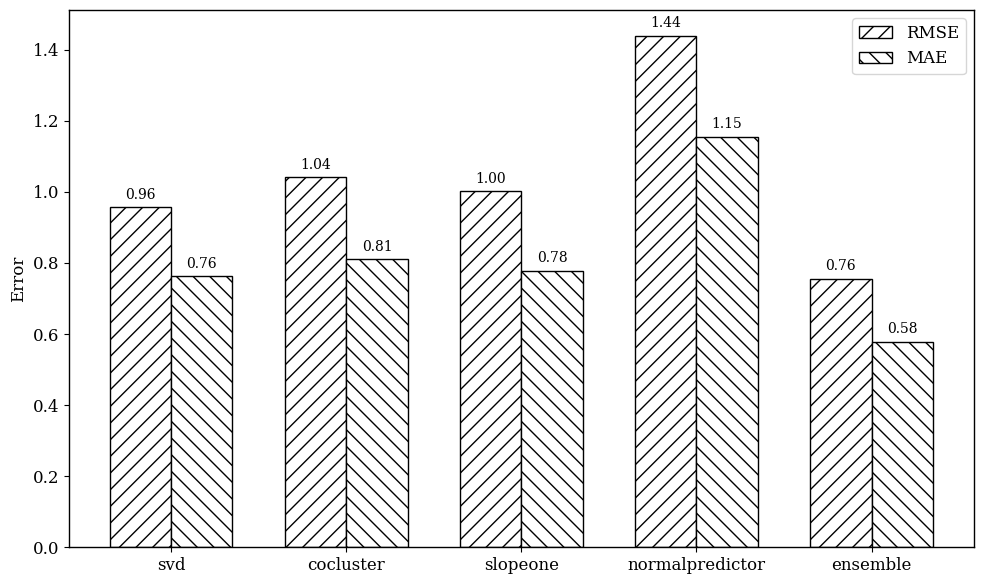

In [ ]:
import matplotlib.pyplot as plt

models = list(rmseNetflix.keys())
n_models = len(models)
x = np.arange(n_models)

# Compute average RMSE and MAE for each model
avg_rmse = [np.mean(rmseNetflix[model]) for model in models]
avg_mae = [np.mean(maeNetflix[model]) for model in models]

# Font and figure settings
font_name = 'serif'  # Use standard, highly legible font
plt.rcParams.update({'font.size': 12, 'font.family': font_name})

# Bar chart setup
width = 0.35  # width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars using black and hatch patterns
bars1 = ax.bar(x - width/2, avg_rmse, width, label='RMSE',
               color='white', edgecolor='black', hatch='//', linewidth=1)
bars2 = ax.bar(x + width/2, avg_mae, width, label='MAE',
               color='white', edgecolor='black', hatch='\\\\', linewidth=1)

# Axis labels and title
ax.set_ylabel('Error', fontsize=12)
#ax.set_title('Average RMSE and MAE by Model', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Annotate bar values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Increase axis line width
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Final layout
plt.tight_layout()

# Save figure in high-quality format
#plt.savefig('bar_result_movielens.tiff', dpi=1200, format='tiff')  # For bitmap submission
plt.savefig('bar_result_netflix.pdf')  # For vector-based submission
plt.show()